<a href="https://colab.research.google.com/github/Suhit97/Dog_breed_classification/blob/main/Pytorch_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile

data_zip = '/content/gdrive/MyDrive/Dog_Breed_Classification/train.zip'
zip_ref = zipfile.ZipFile(data_zip, 'r')
zip_ref.extractall('/content/gdrive/My Drive/Dog_Breed_Classification/train')
zip_ref.close()

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn import  model_selection


from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader



%matplotlib inline

In [14]:
train_path = '/content/gdrive/MyDrive/Dog_Breed_Classification/train'
test_path = '/content/gdrive/MyDrive/Dog_Breed_Classification/test'

In [15]:
label_df = pd.read_csv("/content/gdrive/MyDrive/Dog_Breed_Classification/labels.csv")
label_df

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


In [16]:
label_df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [17]:
labels = [ "beagle", "chihuahua", "doberman", "french_bulldog", "golden_retriever", "malamute", "pug", "saint_bernard", "scottish_deerhound", "tibetan_mastiff"]

label_new = label_df[label_df.breed.isin(labels)]

label_new.breed.value_counts()

scottish_deerhound    126
beagle                105
pug                    94
saint_bernard          84
malamute               81
doberman               74
chihuahua              71
french_bulldog         70
tibetan_mastiff        69
golden_retriever       67
Name: breed, dtype: int64

In [18]:
# Encoding the labels
label_new['label'] = LabelEncoder().fit_transform(label_new.breed)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
dict_label = label_new[['label','breed']].copy()
dict_label.drop_duplicates(inplace=True)
dict_label.set_index('label', drop=True, inplace=True)
index_to_breed = dict_label.to_dict()['breed']

In [20]:
import pickle
# Saving to disk
pickle.dump(index_to_breed, open('/content/gdrive/MyDrive/Dog_Breed_Classification/data_conv.pkl', 'wb'))

In [21]:
label_new.id = label_new.id.apply(lambda x: x+'.jpg')
label_new.id = label_new.id.apply(lambda x: train_path+'/'+x)

label_new.drop(['breed'], axis=1, inplace=True)
label_new.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,label
4,/content/gdrive/MyDrive/Dog_Breed_Classificati...,4
9,/content/gdrive/MyDrive/Dog_Breed_Classificati...,8
20,/content/gdrive/MyDrive/Dog_Breed_Classificati...,2
25,/content/gdrive/MyDrive/Dog_Breed_Classificati...,4
37,/content/gdrive/MyDrive/Dog_Breed_Classificati...,4


In [22]:
def show_images(df,img_num):
    sample = df.sample(img_num)
    paths = sample.id.tolist()
    for path in paths:
        plt.figure(figsize=(4,4))
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

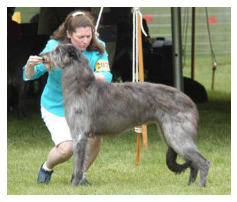

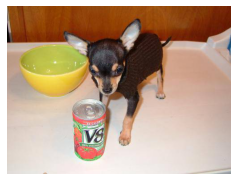

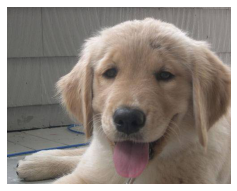

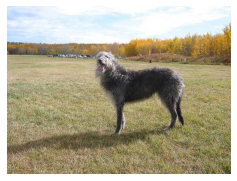

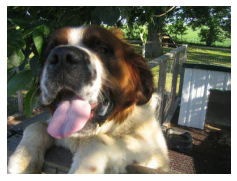

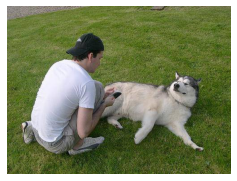

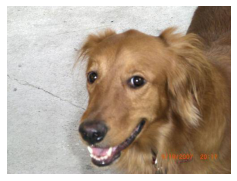

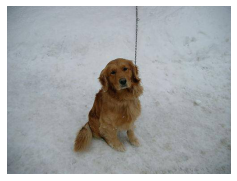

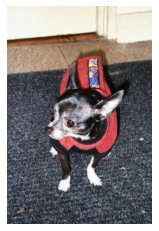

In [23]:
show_images(label_new,9)

In [ ]:
df_train, df_valid = model_selection.train_test_split(
                    label_new,
                    test_size=0.16,
                    random_state=42,
                    stratify=label_new.label  # To address Label Imbalance
)

print(f'Train size : {df_train.shape[0]}')
print(f'valid size : {df_valid.shape[0]}')

In [ ]:
# reset index on both dataframes
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)


In [ ]:
class DogDataset(Dataset):

    def __init__(self,dataframe,transform=None):

        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, index):

        image = Image.open(self.dataframe.iloc[index,0])
        label = self.dataframe.iloc[index,1]
        if self.transform is not None:
            image = self.transform(image)
        return image,label
        
      

In [ ]:
# Creating transforms
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])



In [ ]:
train_dataset = DogDataset(df_train, train_transformer)
valid_dataset = DogDataset(df_valid, val_transformer)

In [ ]:
batch_size = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(train_loader))
print('Number of valid batches', len(valid_loader))

Number of training batches 71
Number of valid batches 14


In [ ]:
class Model(nn.Module):

    def __init__(self, base_model, base_out_features,num_classes):

        super(Model,self).__init__()
        self.base_model = base_model
        self.linear = nn.Linear(base_out_features, 512)
        self.output = nn.Linear(512, num_classes)

    
    def forward(self, x):

        x = F.relu(self.base_model(x))
        x = F.relu(self.linear(x))
        x = self.output(x)

        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
resnet50 = torchvision.models.resnet50(pretrained=True)
for param in resnet50.parameters():
    param.requires_grad=False

model = Model(base_model=resnet50,
                  base_out_features=resnet50.fc.out_features,
                  num_classes=len(labels))
model.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad], lr = 0.001)

In [ ]:
print(model)

In [ ]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 40
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    # scheduler.step(epoch)
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (valid_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_tutorial.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/40], Step [0/71], Loss: 2.2554
Epoch [1/40], Step [20/71], Loss: 1.1909
Epoch [1/40], Step [40/71], Loss: 1.0852
Epoch [1/40], Step [60/71], Loss: 0.4009

train loss: 1.0599, train acc: 65.5807
validation loss: 0.1615, validation acc: 94.8148

Detected network improvement, saving current model
Epoch 2

Epoch [2/40], Step [0/71], Loss: 0.6753
Epoch [2/40], Step [20/71], Loss: 0.3157
Epoch [2/40], Step [40/71], Loss: 0.4280
Epoch [2/40], Step [60/71], Loss: 1.3136

train loss: 0.8877, train acc: 76.7705
validation loss: 0.1317, validation acc: 97.0370

Detected network improvement, saving current model
Epoch 3

Epoch [3/40], Step [0/71], Loss: 0.1897
Epoch [3/40], Step [20/71], Loss: 0.6638
Epoch [3/40], Step [40/71], Loss: 0.7275
Epoch [3/40], Step [60/71], Loss: 0.3278

train loss: 0.7817, train acc: 81.4448
validation loss: 0.1180, validation acc: 97.7778

Detected network improvement, saving current model
Epoch 4

Epoch [4/40], Step [0/71], Loss: 0.0393
Epoch [4/40]

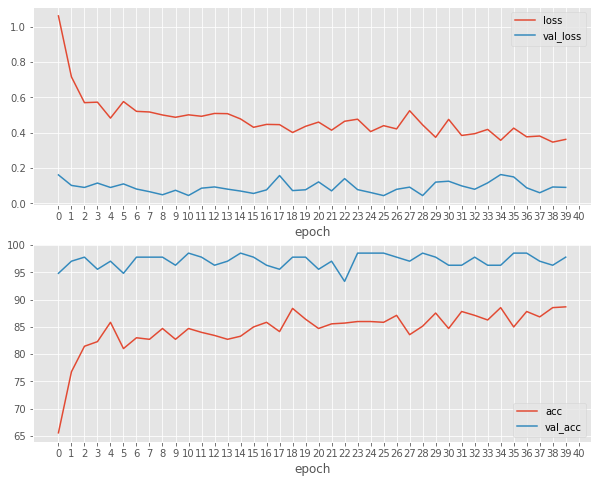

In [ ]:
def plot_result(train_loss,val_loss,train_acc,val_acc):
    plt.style.use('ggplot')
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(train_loss,label='loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(0,n_epochs+1))
    ax2.plot(train_acc, label='acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(0,n_epochs+1))
    plt.show()
plot_result(train_loss,val_loss, train_acc,  val_acc)

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/Dog_Breed_Classification/model_dog_breed_classification.pt')

In [ ]:
model = torch.load('/content/gdrive/MyDrive/Dog_Breed_Classification/model_dog_breed_classification.pt')
model.eval()

Model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
         

In [ ]:


from tqdm import tqdm

Label = []
print('Start predicting....')
with torch.no_grad():
    for x_batch, y_batch in tqdm(valid_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  
        y_test_pred = model(x_batch)
        _, pred = torch.max(y_test_pred, dim = 1)       

        for i in range(len(pred)):        
            Label.append(pred[i].cpu().numpy()) 



  0%|          | 0/14 [00:00<?, ?it/s]

Start predicting....


100%|██████████| 14/14 [01:31<00:00,  6.55s/it]


In [ ]:
copy_df = df_valid.copy()

copy_df['predict'] = Label
copy_df.head()

,id,label,predict
0,/content/gdrive/MyDrive/Dog_Breed_Classificati...,8,7
1,/content/gdrive/MyDrive/Dog_Breed_Classificati...,0,1
2,/content/gdrive/MyDrive/Dog_Breed_Classificati...,2,7
3,/content/gdrive/MyDrive/Dog_Breed_Classificati...,1,8
4,/content/gdrive/MyDrive/Dog_Breed_Classificati...,3,3


In [ ]:
# track test loss
test_loss     = 0.0
class_correct = [0]*10
class_total   = [0]*10

# For generating confusion matrix
conf_matrix = np.zeros((10,10))

# iterate over test data
for data, target in valid_loader:
    data   = data.to(device)
    target = target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1

# average test loss
test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.091620

Test Accuracy of   0: 100% (17/17)
Test Accuracy of   1: 100% (11/11)
Test Accuracy of   2: 100% (12/12)
Test Accuracy of   3: 100% (11/11)
Test Accuracy of   4: 81% ( 9/11)
Test Accuracy of   5: 100% (13/13)
Test Accuracy of   6: 93% (14/15)
Test Accuracy of   7: 100% (14/14)
Test Accuracy of   8: 100% (20/20)
Test Accuracy of   9: 100% (11/11)

Test Accuracy (Overall): 97% (132/135)


[Text(0, 0.5, 'beagle'),
 Text(0, 1.5, 'chihuahua'),
 Text(0, 2.5, 'doberman'),
 Text(0, 3.5, 'french_bulldog'),
 Text(0, 4.5, 'golden_retriever'),
 Text(0, 5.5, 'malamute'),
 Text(0, 6.5, 'pug'),
 Text(0, 7.5, 'saint_bernard'),
 Text(0, 8.5, 'scottish_deerhound'),
 Text(0, 9.5, 'tibetan_mastiff')]

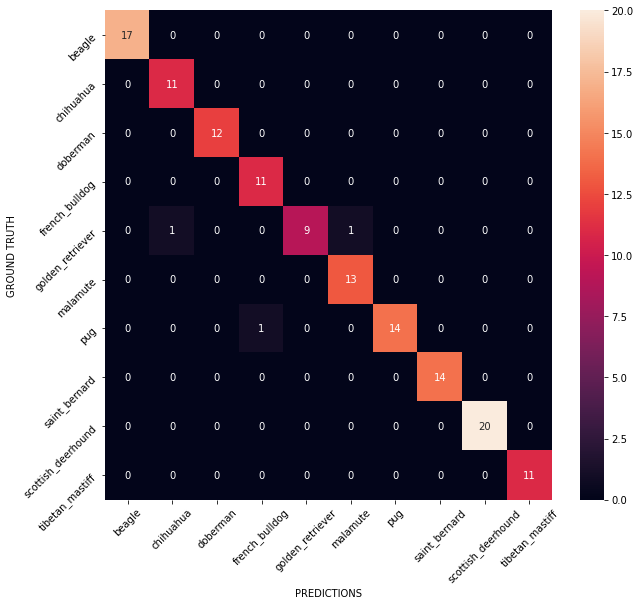

In [ ]:
import seaborn as sns
plt.subplots(figsize=(10,9))
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('PREDICTIONS');
ax.set_ylabel('GROUND TRUTH');
ax.xaxis.set_ticklabels(labels, rotation = 45)
ax.yaxis.set_ticklabels(labels, rotation = 45)